# FPP multi objective optimization

### Setup distributed computing environment

See more details here: https://fuse.help/parallel.html

In [1]:
if gethostname() == "saga.cluster"
    nodes = 4
    np = 30 * nodes
    using Pkg
    Pkg.activate("..")
    using Distributed
    using ClusterManagers
    ENV["JULIA_WORKER_TIMEOUT"] = "180"
    if nprocs() < np
        addprocs(SlurmManager(np - nprocs()), exclusive="", topology=:master_worker, nodelist="saga03,saga04,saga05,saga06,saga07")
    end
else
    using Distributed
    np = length(Sys.cpu_info())
    if nprocs() < np + 1
        addprocs(np - nprocs() + 1, topology=:master_worker)
    end
end
println("Working with $(nprocs()) processes")

  Activating new project at `~/.julia/dev/FUSE/examples`


connecting to worker 1 out of 119
connecting to worker 2 out of 119
connecting to worker 3 out of 119
connecting to worker 4 out of 119
connecting to worker 5 out of 119
connecting to worker 6 out of 119
connecting to worker 7 out of 119
connecting to worker 8 out of 119
connecting to worker 9 out of 119
connecting to worker 10 out of 119
connecting to worker 11 out of 119
connecting to worker 12 out of 119
connecting to worker 13 out of 119
connecting to worker 14 out of 119
connecting to worker 15 out of 119
connecting to worker 16 out of 119
connecting to worker 17 out of 119
connecting to worker 18 out of 119
connecting to worker 19 out of 119
connecting to worker 20 out of 119
connecting to worker 21 out of 119
connecting to worker 22 out of 119
connecting to worker 23 out of 119
connecting to worker 24 out of 119
connecting to worker 25 out of 119
connecting to worker 26 out of 119
connecting to worker 27 out of 119
connecting to worker 28 out of 119
connecting to worker 29 out o

### Import packages

In [2]:
using Revise
using FUSE
using Plots;
gr();
FUSE.logging(Logging.Info; actors=Logging.Error);

[ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]


WebIO._IJuliaInit()

### Get `ini` and `act` for FPP case and custmize as needed

In [3]:
ini, act = FUSE.case_parameters(:FPP; version=:v1_demount, init_from=:scalars)
act.ActorPFcoilsOpt.optimization_scheme = :none; # don't spend time optimizing the PFs

### As a good practice, test the actor/workflow that you want to optimize first

In [4]:
dd = FUSE.init(ini, act)
FUSE.ActorWholeFacility(dd, act);

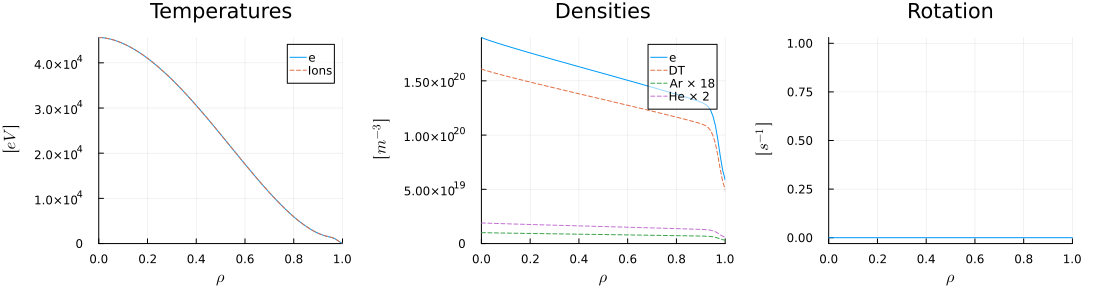

In [5]:
#IMAS.freeze(dd.balance_of_plant)
plot(dd.core_profiles)

### Define optimization variables and ranges

In [6]:
# nominal value and ranges
ini_opt = deepcopy(ini)
ini_opt.ec_launchers.power_launched = ini.ec_launchers.power_launched ↔ [10e6, 200e6];
ini_opt.core_profiles.zeff = ini.core_profiles.zeff ↔ [1.1, 2.5]
#ini_opt.equilibrium.κ = ini.equilibrium.κ ↔ [1.3,2.5]
#ini_opt.equilibrium.δ = ini.equilibrium.δ ↔ [-0.7,0.7]
#ini_opt.equilibrium.ζ = ini.equilibrium.ζ ↔ [0,0.2]
ini_opt.equilibrium.B0 = ini.equilibrium.B0 ↔ [1.0, 20.]
ini_opt.equilibrium.ip = ini.equilibrium.ip ↔ [1.0e6, 22e6]
ini_opt.equilibrium.R0 = ini.equilibrium.R0 ↔ [ini.equilibrium.R0, 10.0];

### Define the optimization objectives

In [7]:
# FUSE comes with a library of objective functions
OFL = deepcopy(FUSE.ObjectivesFunctionsLibrary)
OFL[:max_power_electric_net].target = 200.0
#objective_functions = [OFL[:max_power_electric_net], OFL[:min_log10_levelized_CoE], OFL[:max_log10_flattop], OFL[:min_βn]]
objective_functions = [OFL[:min_log10_levelized_CoE], OFL[:min_βn]]

CFL = deepcopy(FUSE.ConstraintFunctionsLibrary)
CFL[:target_power_electric_net].limit = 200.0
CFL[:target_power_electric_net].tolerance = 0.01
constraint_functions = [CFL[:target_power_electric_net], CFL[:steady_state]]

# ...but one can define custom objectives and constraints too
# target_power_electric = FUSE.ObjectiveFunction(:target_power_electric_net, "MW", dd -> @ddtime(dd.balance_of_plant.power_electric_net)/1E6, 200)
#objective_functions = [target_power_electric, OFL[:min_cost], OFL[:max_flattop]]

display(objective_functions)
display(map(func -> func(dd), objective_functions))

display(constraint_functions)
display(map(func -> func(dd), constraint_functions))

2-element Vector{FUSE.ObjectiveFunction}:
 min_log10_levelized_CoE → -Inf [log₁₀($/kW)]
 min_βn → -Inf []

2-element Vector{Float64}:
 -0.8448824001267154
  4.998079860653735

2-element Vector{FUSE.ConstraintFunction}:
 target_power_electric_net == 200.0 ± 2.0 [MW]
 steady_state > 1.0 [log₁₀(hours)]

2-element Vector{Float64}:
  1.1911107396692824
 -1.9768970456407593

In [ ]:
save_folder="/mnt/beegfs/users/meneghini/optimization_runs_simple_NSGA2"

# option to resume an optimization where it was left off
if false
    continue_results = results
else
    continue_results = missing
end

# define optimization parameters
# For real optimization studies the population size (N) and number of iterations should be bigger
# eg. N=100, iterations=25
optimization_parameters = Dict(
    :N => 200, # even number
    :iterations => 200,
    :continue_results => continue_results,
    :save_folder => save_folder)

# run optimization
results = FUSE.workflow_multiobjective_optimization(ini_opt, act, FUSE.ActorWholeFacility, objective_functions, constraint_functions; optimization_parameters...);

Running on 119 worker processes
== Actuators ==
ini.equilibrium.B0
- units: T
- description: Vacuum toroidal field at R0 [T]; Positive sign means anti-clockwise when viewing from above. The product R0B0 must be consistent with the b_tor_vacuum_r field of the tf IDS.
- value: 4.713171689711136
- base: 4.713171689711136
- default: missing
- lower: 1.0
- upper: 20.0
ini.equilibrium.R0
- units: m
- description: Geometric genter of the plasma. NOTE: This also scales the radial build layers.
- value: 4.824432302041749
- base: 4.824432302041749
- default: missing
- lower: 4.824432302041749
- upper: 10.0
ini.equilibrium.ip
- units: A
- description: Plasma current (toroidal component). Positive sign means anti-clockwise when viewed from above.
- value: 9.01450949691727e6
- base: 9.01450949691727e6
- default: missing
- lower: 1.0e6
- upper: 2.2e7
ini.core_profiles.zeff
- units: -
- description: Effective ion charge
- value: 2.0
- base: 2.0
- default: missing
- lower: 1.1
- upper: 2.5
ini.ec_laun

Iteration   6%|█▋                          |  ETA: 15:05:58 ( 4.82  m/it)

### Reload optimization results from file

In [ ]:
# Optimization results can be re-loaded this way:
filename = joinpath(save_folder, "optimization.bson")
@time results = FUSE.load_optimization(filename);

### Plot multi-objective optimization results

In [ ]:
extract_inputs = Dict(
    :Paux => (dd, ini, act) -> ini.ec_launchers.power_launched / 1E6,
    :zeff => (dd, ini, act) -> ini.core_profiles.zeff,
    :κ => (dd, ini, act) -> ini.equilibrium.κ,
    :δ => (dd, ini, act) -> ini.equilibrium.δ,
    :ζ => (dd, ini, act) -> ini.equilibrium.ζ,
    :B0 => (dd, ini, act) -> ini.equilibrium.B0,
    :ip => (dd, ini, act) -> ini.equilibrium.ip / 1E6,
    :R0 => (dd, ini, act) -> ini.equilibrium.R0,
)

extract_outputs = Dict(
    :beta_n => (dd, ini, act) -> dd.equilibrium.time_slice[].global_quantities.beta_normal,
    :log10_levelized_CoE => (dd, ini, act) -> log10(dd.costing.levelized_CoE),
    #:Pfusion => (dd, ini, act) -> IMAS.fusion_power(dd.core_profiles.profiles_1d[]) / 1E6,
    :Pelectric => (dd, ini, act) -> @ddtime(dd.balance_of_plant.power_electric_net) / 1E6,
    :log10_flattop => (dd, ini, act) -> log10(dd.build.oh.flattop_duration / 3600.0)
)

path="optimization_runs_betan"
dirs = filter(x->!isfile(joinpath(x,"error.txt")),filter(isdir,sort(readdir(path; join=true))))#[end-1000:end]
println(length(dirs))
inputs,outputs = FUSE.load(dirs, [extract_inputs, extract_outputs]);

In [ ]:
using Plots
display(plot([histogram(inputs[:,name], title=name, label="") for name in names(inputs)]...))
plot([histogram(outputs[:,name], title=name, label="") for name in names(outputs)]...)

In [ ]:
xname="log10_levelized_CoE"
x=outputs[:,xname]
yname="Pelectric"
y=outputs[:,yname]
cname="beta_n"
c=outputs[:,cname]
scatter(x, y, marker_z=c ,xlabel=xname, ylabel=yname, colorbar_title=cname, marker=:circle, markerstrokewidth=0, label="")

### How to: Define and use a custom FUSE workflow

In [ ]:
# Here `@everywhere` is needed to make all processes aware of the custom function
@everywhere function workflow_custom(ini, act)
    FUSE.init(dd, ini, act)
    FUSE.ActorEquilibriumTransport(dd, act)
    FUSE.ActorCXbuild(dd, act)
    return dd
end

# results = FUSE.workflow_multiobjective_optimization(ini, act, custom_workflow, objective_functions; optimization_parameters...);